## Prerequisites
Pip packages:
* networkx
* python-louvain

Alternatives
* igraph ( http://igraph.org/redirect.html ) built in C/C++ for performance, available wrappers for R and Python.
* graph-tool ( http://graph-tool.skewed.de/ ) built in C++, supports OpenMP, available wrapper for Python.

**TODO** Explicar que es una red, que es un grafo, nodo, arista, grado, tamaño, direccion, matriz de adyacencia

# Importing networks

It's the Marvel Universe Social Graph dataset constructed by Cesc Rosselló, Ricardo Alberich, and Joe Miro

In [1]:
import networkx as nx

In [2]:
HERO_NET = "../PDSC2-Ch07-code/data/hero-network.csv"

In [3]:
!head $HERO_NET

"LITTLE, ABNER","PRINCESS ZANDA"
"LITTLE, ABNER","BLACK PANTHER/T'CHAL"
"BLACK PANTHER/T'CHAL","PRINCESS ZANDA"
"LITTLE, ABNER","PRINCESS ZANDA"
"LITTLE, ABNER","BLACK PANTHER/T'CHAL"
"BLACK PANTHER/T'CHAL","PRINCESS ZANDA"
"STEELE, SIMON/WOLFGA","FORTUNE, DOMINIC"
"STEELE, SIMON/WOLFGA","ERWIN, CLYTEMNESTRA"
"STEELE, SIMON/WOLFGA","IRON MAN/TONY STARK "
"STEELE, SIMON/WOLFGA","IRON MAN IV/JAMES R."


In [4]:
import csv

def graph_from_csv(path):
    graph = nx.Graph(name="Heroic Social Network")
    with open(path, 'r') as data:
        reader = csv.reader(data)
        for row in reader:
            graph.add_edge(*row)
            
    return graph

In [5]:
graph = graph_from_csv(HERO_NET)
print("Order:",graph.order())
print("Size:",graph.size())

Order: 6426
Size: 167219


In [6]:
HERO_NET_GDF = "../PDSC2-Ch07-code/data/comic-hero-network.gdf"

In [7]:
!head $HERO_NET_GDF

nodedef>name VARCHAR,type VARCHAR
"2001 10",comic
"2001 8",comic
"2001 9",comic
"24-HOUR MAN/EMMANUEL",hero
"3-D MAN/CHARLES CHAN",hero
"4-D MAN/MERCURIO",hero
"8-BALL/",hero
"A '00",comic
"A '01",comic


In [8]:
def graph_from_gdf(path):
    graph = nx.Graph(name="Characters in Comics")
    with open(path, 'r') as data:
        reader = csv.reader(data)
        for row in reader:
            if 'nodedef' in row[0]:
                handler = lambda row,G: G.add_node(row[0], TYPE=row[1])
            elif 'edgedef' in row[0]:
                handler = lambda row,G: G.add_edge(*row)
            else:
                handler(row, graph)
    return graph

In [9]:
graph = graph_from_gdf(HERO_NET_GDF)

In [10]:
print(nx.info(graph))

Name: Characters in Comics
Type: Graph
Number of nodes: 19090
Number of edges: 96104
Average degree:  10.0685


# Exploring subgraphs within a heroic network

In [11]:
import matplotlib.pyplot as plt

def draw_ego_graph(graph, character, hops=1):
    """
    Expecting a graph_from_gdf
    """
    # Get the Ego Graph and Position
    ego = nx.ego_graph(graph, character, hops)
    pos = nx.spring_layout(ego)
    plt.figure(figsize=(12,12))
    plt.axis('off')
    # Coloration and Configuration
    ego.node[character]["TYPE"] = "center"
    valmap = { "comic": 0.25, "hero": 0.54, "center": 0.87 }
    types = nx.get_node_attributes(ego, "TYPE")
    values = [valmap.get(types[node], 0.25) for node in ego.nodes()]

    # Draw
    nx.draw_networkx_edges(ego, pos, alpha=0.4)
    nx.draw_networkx_nodes(ego, pos, node_size=80, node_color=values, cmap=plt.cm.hot, with_labels=False)
    
    plt.show()

/opt/anaconda/3/envs/social-network-analysis/lib/python3.6/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/anaconda/3/envs/social-network-analysis/lib/python3.6/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


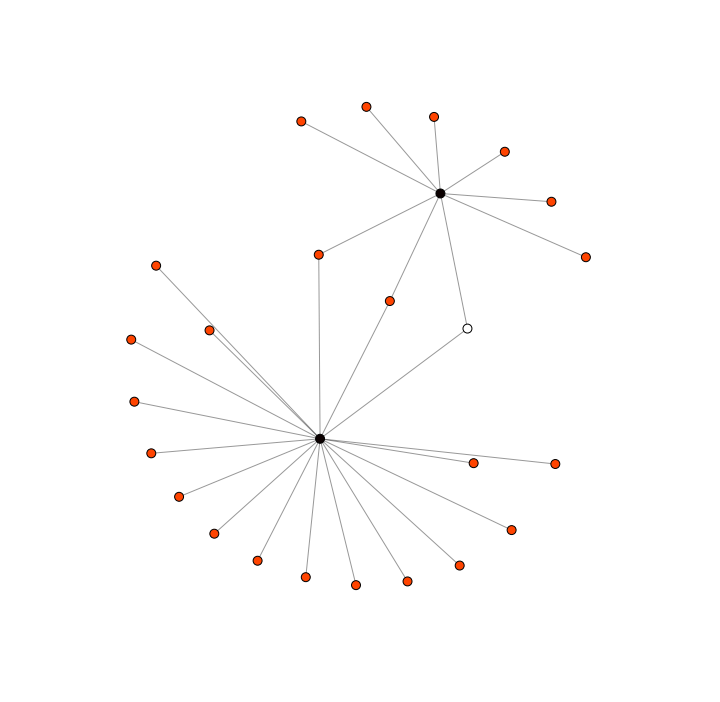

In [12]:
draw_ego_graph(graph, "LONGBOW/AMELIA GREER", hops=2)

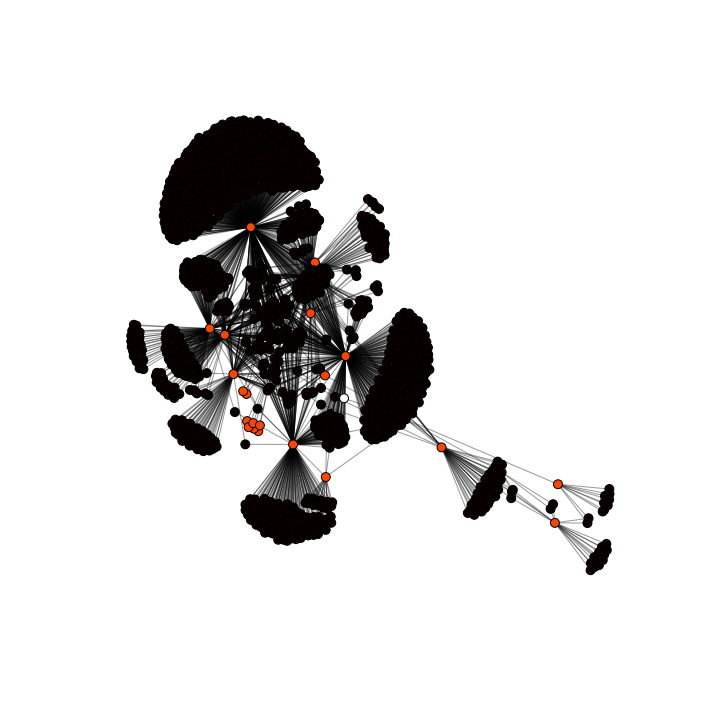

In [13]:
draw_ego_graph(graph, "LONGBOW/AMELIA GREER", hops=3)

## Finding strong ties

In [14]:
def transform_to_weighted_heros(graph):
    # Create new graph to fill in
    heros = nx.Graph(name="Weighted Heroic Social Network")
    # Iterate through all the nodes and their properties
    for node, data in graph.nodes(data=True):
    # We don't care about comics, only heros
        if data['TYPE'] == 'comic': continue
        # Add the hero and their properties (this will also update data)
        heros.add_node(node, **data)
        # Find all the heros connected via the comic books
        for comic in graph[node]:
            for alter in graph[comic]:
                # Skip the hero that we're on
                if alter == node: continue
                # Setup the default edge
                if alter not in heros[node]:
                    heros.add_edge(node, alter, weight=0.0,label="knows")
                # The weight of the hero is the fraction of connections / 2
                heros[node][alter]["weight"] += 1.0 / (graph.degree(comic) *2)
    return heros

In [15]:
def draw_weighted_ego_graph(graph, character, hops=1):
    # Graph and Position
    ego = nx.ego_graph(graph, character, hops)
    pos = nx.spring_layout(ego)
    plt.figure(figsize=(12,12))
    plt.axis('off')
    # Coloration and Configuration
    ego.node[character]["TYPE"] = "center"
    valmap = { "hero": 0.0, "center": 1.0 }
    types = nx.get_node_attributes(ego, "TYPE")
    values = [valmap.get(types[node], 0.25) for node in ego.nodes()]
    char_edges = ego.edges(data=True, nbunch=[character,])
    nonchar_edges = ego.edges(nbunch=[n for n in ego.nodes() if n != character])
    elarge=[(u,v) for (u,v,d) in char_edges if d['weight'] >=0.12]
    esmall=[(u,v) for (u,v,d) in char_edges if d['weight'] < 0.12]
    print(set([d['weight'] for (u,v,d) in char_edges]))
    # Draw
    nx.draw_networkx_nodes(ego, pos, node_size=200, node_color=values, cmap=plt.cm.Paired, with_labels=False)
    nx.draw_networkx_edges(ego,pos,edgelist=elarge, width=1.5, edge_color='b')
    nx.draw_networkx_edges(ego,pos,edgelist=esmall, width=1,alpha=0.5, edge_color='b',style='dashed')
    nx.draw_networkx_edges(ego,pos,edgelist=nonchar_edges, width=0.5,alpha=0.2,style='dashed')
    plt.show()

{0.05555555555555555, 0.16666666666666666, 0.1111111111111111}


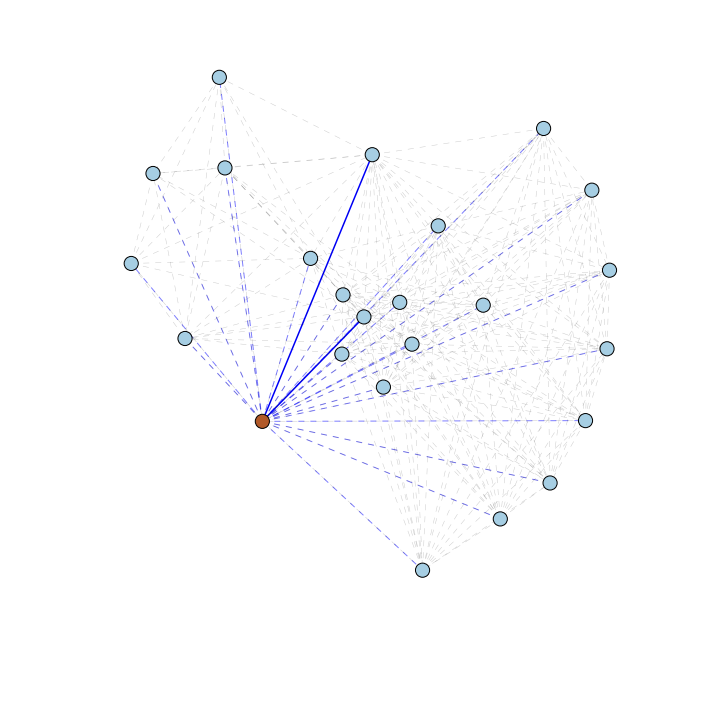

In [16]:
graph = transform_to_weighted_heros(graph)
draw_weighted_ego_graph(graph, "LONGBOW/AMELIA GREER", hops=1)

## Finding key players

In [17]:
import operator

In [18]:
graph = graph_from_csv(HERO_NET)

In [19]:
degrees = sorted(graph.degree().items(), key=operator.itemgetter(1), reverse=True)

In [20]:
degrees[0:9]

[('CAPTAIN AMERICA', 1908),
 ('SPIDER-MAN/PETER PAR', 1737),
 ('IRON MAN/TONY STARK ', 1522),
 ('THING/BENJAMIN J. GR', 1416),
 ('MR. FANTASTIC/REED R', 1379),
 ('WOLVERINE/LOGAN ', 1371),
 ('HUMAN TORCH/JOHNNY S', 1361),
 ('SCARLET WITCH/WANDA ', 1325),
 ('THOR/DR. DONALD BLAK', 1289)]

In [21]:
centrality = nx.degree_centrality(graph)
nx.set_node_attributes(graph, 'centrality', centrality)
degrees = sorted(centrality.items(), key=operator.itemgetter(1), reverse=True)
degrees[0:9]

[('CAPTAIN AMERICA', 0.2969649805447471),
 ('SPIDER-MAN/PETER PAR', 0.2703501945525292),
 ('IRON MAN/TONY STARK ', 0.23688715953307396),
 ('THING/BENJAMIN J. GR', 0.2203891050583658),
 ('MR. FANTASTIC/REED R', 0.21463035019455254),
 ('WOLVERINE/LOGAN ', 0.21338521400778213),
 ('HUMAN TORCH/JOHNNY S', 0.21182879377431907),
 ('SCARLET WITCH/WANDA ', 0.20622568093385216),
 ('THOR/DR. DONALD BLAK', 0.20062256809338522)]

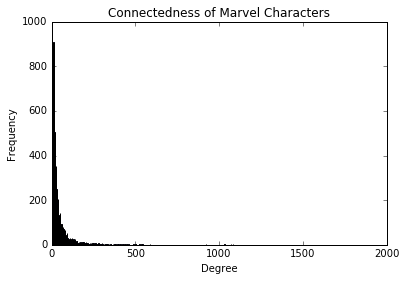

In [23]:
plt.hist(list(graph.degree().values()), bins=500)
plt.title("Connectedness of Marvel Characters")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

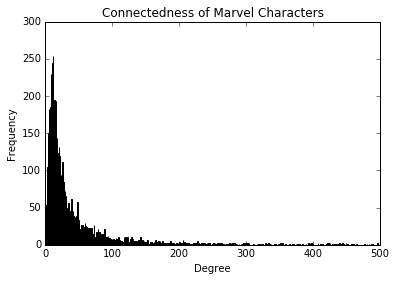

In [24]:
degrees_of_988 = filter(lambda v: v < 500, graph.degree().values())
plt.hist(list(degrees_of_988), bins=500)
plt.title("Connectedness of Marvel Characters")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

In [25]:
def nbest_centrality(graph, metric, n=10, attribute="centrality", **kwargs):
    centrality = metric(graph, **kwargs)
    nx.set_node_attributes(graph, attribute, centrality)
    degrees = sorted(centrality.items(), key=operator.itemgetter(1), reverse=True)
    print("Top %i based on %s metric" % (n, metric.__name__))
    for idx, item in enumerate(degrees[0:n]):
        item = (idx+1,) + item
        print("%i. %s: %0.3f" % item)

In [26]:
nbest_centrality(graph, nx.degree_centrality)

Top 10 based on degree_centrality metric
1. CAPTAIN AMERICA: 0.297
2. SPIDER-MAN/PETER PAR: 0.270
3. IRON MAN/TONY STARK : 0.237
4. THING/BENJAMIN J. GR: 0.220
5. MR. FANTASTIC/REED R: 0.215
6. WOLVERINE/LOGAN : 0.213
7. HUMAN TORCH/JOHNNY S: 0.212
8. SCARLET WITCH/WANDA : 0.206
9. THOR/DR. DONALD BLAK: 0.201
10. BEAST/HENRY &HANK& P: 0.197


In [27]:
nbest_centrality(graph, nx.betweenness_centrality, normalized=True)

Top 10 based on betweenness_centrality metric
1. SPIDER-MAN/PETER PAR: 0.074
2. CAPTAIN AMERICA: 0.057
3. IRON MAN/TONY STARK : 0.037
4. WOLVERINE/LOGAN : 0.036
5. HAVOK/ALEX SUMMERS : 0.036
6. DR. STRANGE/STEPHEN : 0.029
7. THING/BENJAMIN J. GR: 0.025
8. HAWK: 0.025
9. HULK/DR. ROBERT BRUC: 0.024
10. MR. FANTASTIC/REED R: 0.024


In [28]:
nbest_centrality(graph, nx.closeness_centrality)

Top 10 based on closeness_centrality metric
1. CAPTAIN AMERICA: 0.584
2. SPIDER-MAN/PETER PAR: 0.574
3. IRON MAN/TONY STARK : 0.561
4. THING/BENJAMIN J. GR: 0.558
5. MR. FANTASTIC/REED R: 0.556
6. WOLVERINE/LOGAN : 0.555
7. HUMAN TORCH/JOHNNY S: 0.555
8. SCARLET WITCH/WANDA : 0.552
9. THOR/DR. DONALD BLAK: 0.551
10. BEAST/HENRY &HANK& P: 0.549


In [29]:
nbest_centrality(graph, nx.eigenvector_centrality_numpy)

Top 10 based on eigenvector_centrality_numpy metric
1. CAPTAIN AMERICA: 0.117
2. IRON MAN/TONY STARK : 0.103
3. SCARLET WITCH/WANDA : 0.101
4. THING/BENJAMIN J. GR: 0.101
5. SPIDER-MAN/PETER PAR: 0.100
6. MR. FANTASTIC/REED R: 0.100
7. VISION : 0.099
8. HUMAN TORCH/JOHNNY S: 0.099
9. WOLVERINE/LOGAN : 0.098
10. BEAST/HENRY &HANK& P: 0.096


## Exploring the characteristics of entire networks

In [30]:
nx.density(graph)

0.00810031232553549

In [31]:
nx.density(nx.ego_graph(graph, "LONGBOW/AMELIA GREER"))

0.7210144927536232

In [32]:
subgraphs = list(nx.connected_component_subgraphs(graph))

In [33]:
for subgraph in subgraphs:
    print(subgraph.order())

6408
9
7
2


In [34]:
for subgraph in subgraphs:
    print(nx.diameter(subgraph))
    print(nx.average_shortest_path_length(subgraph))

5
2.6384312219371484
2
1.0555555555555556
1
1.0
1
1.0


## Clustering and community detection in social networks

In [35]:
import community

In [36]:
#graph = graph_from_csv(HERO_NETWORK)
partition = community.best_partition(graph)
print("%i partitions" % len(set(partition.values())))
nx.set_node_attributes(graph, 'partition', partition)

31 partitions


In [40]:
def detect_communities(graph):
    partition = community.best_partition(graph)
    nx.set_node_attributes(graph, 'partition', partition)
    return graph, partition

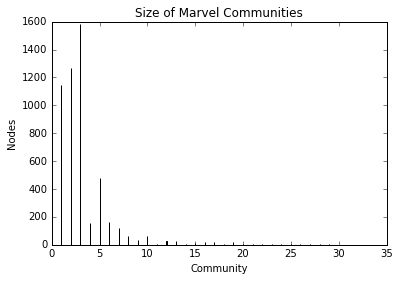

In [48]:
def communities_histogram(graph):
    graph, partition = detect_communities(graph)
    plt.hist(list(partition.values()), bins=len(partition.values()))#, color="#0f6dbc")
    plt.title("Size of Marvel Communities")
    plt.xlabel("Community")
    plt.ylabel("Nodes")
    plt.show()
    
communities_histogram(graph)

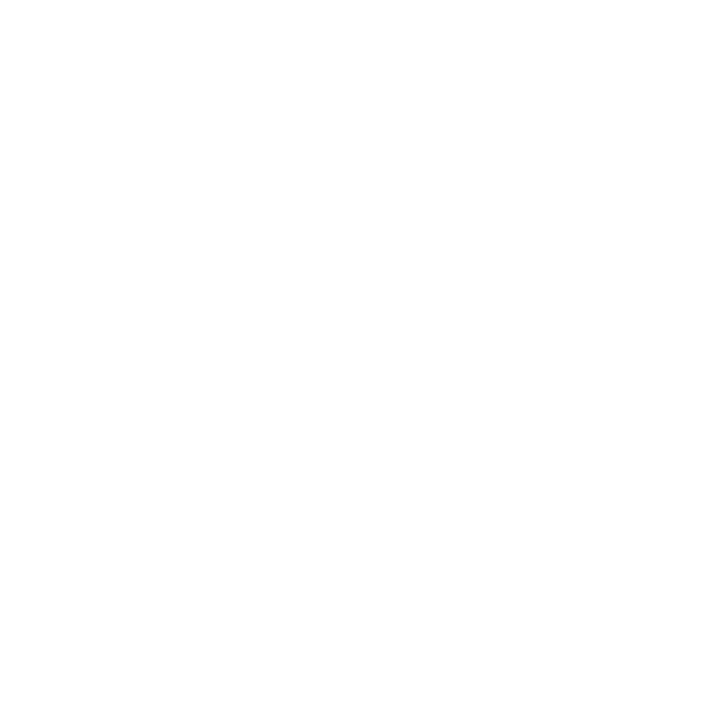

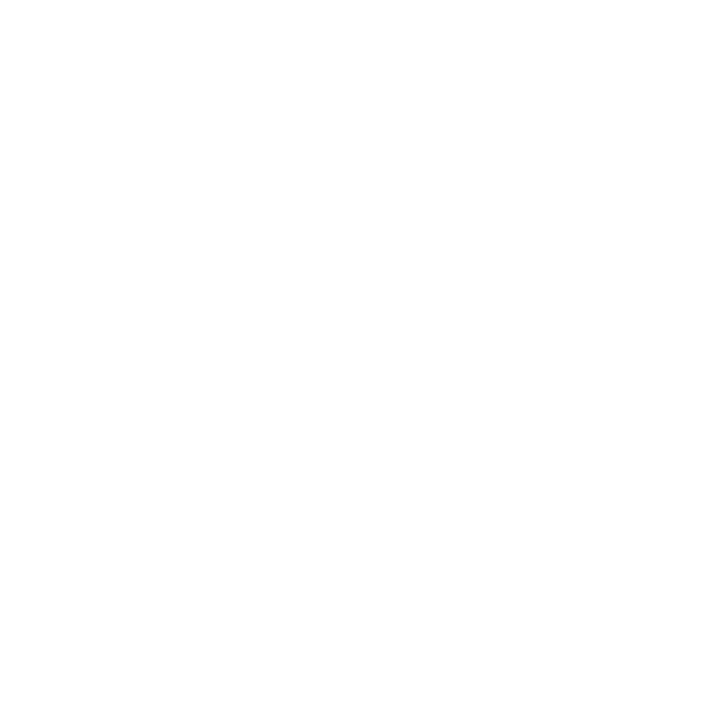

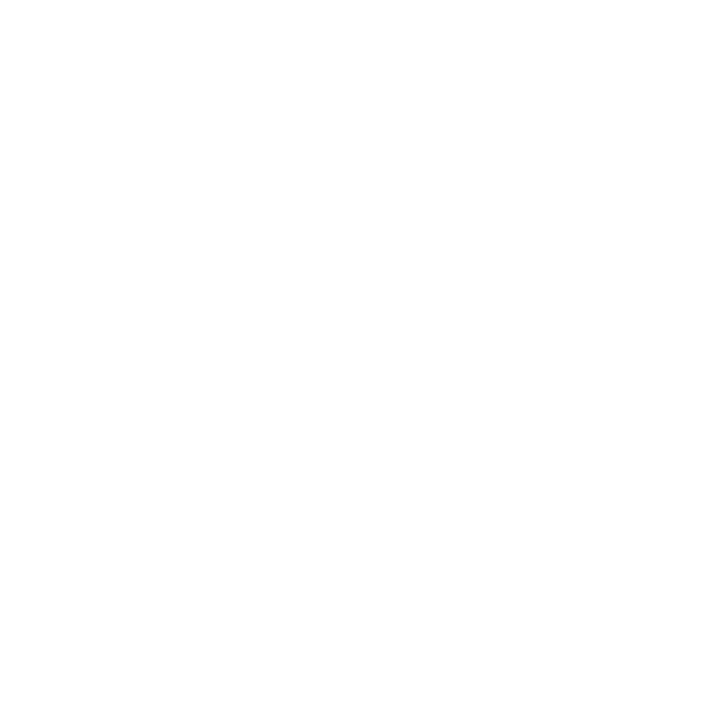

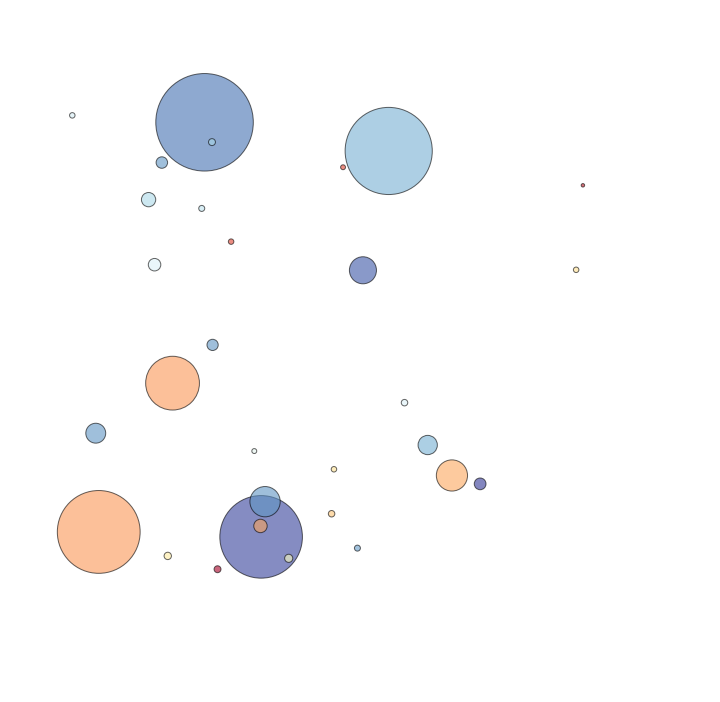

In [54]:
import random
from collections import defaultdict

def communities_bubblechart(graph):
    graph, partition = detect_communities(graph)
    parts = defaultdict(int)
    for part in partition.values():
        parts[part] += 1
    bubbles = nx.Graph()
    for part in parts.items():
        bubbles.add_node(part[0], size=part[1])
    pos = nx.random_layout(bubbles)
    plt.figure(figsize=(12,12))
    plt.axis('off')
    nx.draw_networkx_nodes(bubbles, pos, alpha=0.6, 
                           node_size=list(map(lambda x: x*6, parts.values())), 
                           node_color=[random.random() for x in parts.values()], 
                           cmap=plt.cm.RdYlBu)
    plt.show()
    
communities_bubblechart(graph)

In [55]:
nx.transitivity(graph)

0.19453974709267596

In [56]:
nx.average_clustering(graph)

0.774654121711063